In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [62]:
import numpy as np

import ujson
import attr
import random
import torch

from glob import glob
from tqdm import tqdm_notebook
from itertools import islice
from boltons.iterutils import pairwise, chunked_iter
from collections import Counter

from gensim.models import KeyedVectors
from sklearn.metrics import classification_report, accuracy_score

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [5]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [7]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def abstract_batches(self, size):
        for chunk in chunked_iter(self.abstracts(), size):
            yield AbstractBatch(chunk)

In [8]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
    
    def tensor(self):
        return torch.stack([s.tensor() for s in self.sentences])

In [9]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [21]:
@attr.s
class AbstractBatch:
    
    abstracts = attr.ib()
    
    def tensor(self):
        tensors = [a.tensor() for a in self.abstracts]
        return torch.cat(tensors)
    
    def xy(self, encoded_sents):
        
        x, y = [], []
        
        start = 0
        for ab in self.abstracts:
            sents = encoded_sents[start:start+len(ab.sentences)]
            for s1, s2 in pairwise(sents):
                
                # Correct.
                x.append(torch.cat([s1, s2]))
                y.append(1)
                
                # Incorrect.
                x.append(torch.cat([s2, s1]))
                y.append(0)
                
            start += len(ab.sentences)
            
        return torch.stack(x), torch.FloatTensor(y)

In [75]:
class SentenceEncoder(nn.Module):
    
    def __init__(self, embed_dim=300, lstm_dim=128):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(embed_dim, lstm_dim, batch_first=True)
        
    def forward(self, x):
        h0 = Variable(torch.zeros(1, len(x), self.lstm_dim))
        c0 = Variable(torch.zeros(1, len(x), self.lstm_dim))
        _, (hn, cn) = self.lstm(x, (h0, c0))
        return hn

In [80]:
class Model(nn.Module):
    
    def __init__(self, lstm_dim=128, lin_dim=128):
        super().__init__()
        self.lin1 = nn.Linear(2*lstm_dim, lin_dim)
        self.lin2 = nn.Linear(lin_dim, lin_dim)
        self.lin3 = nn.Linear(lin_dim, lin_dim)
        self.out = nn.Linear(lin_dim, 1)
        
    def forward(self, x):
        y = F.relu(self.lin1(x))
        y = F.relu(self.lin2(y))
        y = F.relu(self.lin3(y))
        y = F.sigmoid(self.out(y))
        return y

In [87]:
train = Corpus('../data/train.json/*.json', 1000)

In [94]:
torch.manual_seed(1)
sent_encoder = SentenceEncoder()
model = Model()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [95]:
train_loss = []
for epoch in range(20):

    epoch_loss = 0
    for batch in train.abstract_batches(50):

        sent_encoder.zero_grad()
        model.zero_grad()

        sents = Variable(batch.tensor())
        sents = sent_encoder(sents)

        x, y = batch.xy(sents.squeeze())
        y = Variable(y)

        y_pred = model(x)
        y_pred = y_pred.view(-1)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.data[0]
        
    train_loss.append(epoch_loss)
    
    print(f'Epoch {epoch}')
    print(epoch_loss)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 0
13.838506579399109


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 1
13.604329586029053


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 2
13.44834178686142


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 3
13.326165676116943


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 4
13.191020846366882


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 5
13.101814031600952


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 6
13.038941085338593


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 7
12.901355385780334


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 8
12.83471292257309


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 9
12.789848446846008


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 10
12.753397941589355


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 11
12.861307144165039


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 12
12.860872864723206


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 13
12.656230330467224


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 14
12.51893299818039


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 15
12.425228476524353


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 16
12.53869217634201


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 17
12.632905721664429


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 18
12.328587472438812


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch 19
12.244929254055023


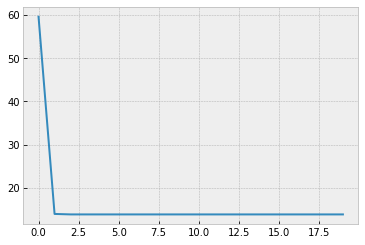

In [90]:
plt.plot(train_loss)

In [91]:
dev = Corpus('../data/dev.json/*.json', 1000)

In [92]:
yt = []
yp = []

for batch in dev.abstract_batches(30):

    sents = Variable(batch.tensor())
    sents = sent_encoder(sents)

    x, y = batch.xy(sents.squeeze())
    y = Variable(y)

    y_pred = model(x)
    y_pred = y_pred.view(-1)
    
    yt += y.data.tolist()
    yp += y_pred.round().data.tolist()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [93]:
print(classification_report(yt, yp))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      4327
        1.0       0.50      1.00      0.67      4327

avg / total       0.25      0.50      0.33      8654



/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
accuracy_score(yt, yp)

0.58828287497111165